# MSc Thesis

In [1]:
# Import required libraries
import json
import pandas as pd
from typing import List, Dict, Any, Set
import numpy as np
from dotenv import load_dotenv
import os
from openai import OpenAI
from time import sleep

# Function to load JSONL file
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Load the development set
dev_data = load_jsonl('datasets/musique/musique_full_v1.0_dev.jsonl')

# Create a DataFrame for better visualization
df = pd.DataFrame(dev_data)

# Display basic information about the dataset
print("Dataset size:", len(df))
print("\nColumns:", df.columns.tolist())

# Basic analysis of paragraphs
def analyze_paragraphs(row):
    return {
        'num_paragraphs': len(row['paragraphs']),
        'supporting_paragraphs': sum(1 for p in row['paragraphs'] if p.get('is_supporting', False))
    }

paragraph_stats = df.apply(analyze_paragraphs, axis=1)
paragraph_stats_df = pd.DataFrame(paragraph_stats.tolist())

print("\nParagraph Statistics:")
print("Average number of paragraphs per example:", paragraph_stats_df['num_paragraphs'].mean())
print("Average number of supporting paragraphs:", paragraph_stats_df['supporting_paragraphs'].mean())
print("Average number of supporting paragraphs:", df['answerable'].value_counts())

Dataset size: 4834

Columns: ['id', 'paragraphs', 'question', 'question_decomposition', 'answer', 'answer_aliases', 'answerable']

Paragraph Statistics:
Average number of paragraphs per example: 19.988829127016963
Average number of supporting paragraphs: 1.8893256102606537
Average number of supporting paragraphs: answerable
False    2417
True     2417
Name: count, dtype: int64


In [2]:
# Display first few examples
df.head()

,id,paragraphs,question,question_decomposition,answer,answer_aliases,answerable
0,2hop__153573_109006,"[{'idx': 0, 'title': 'History of the Internet'...",Who developed the eponymous character from the...,"[{'id': 153573, 'question': 'What series is Mi...",Walt Disney,[],False
1,4hop1__129721_32392_823060_610794,"[{'idx': 0, 'title': 'Zubly Cemetery', 'paragr...",What county is the city that shares a border w...,"[{'id': 129721, 'question': 'In which state is...",Richland County,[],False
2,3hop2__655849_223623_162182,"[{'idx': 0, 'title': 'Broward Correctional Ins...",In what region of the country containing A Lướ...,"[{'id': 655849, 'question': 'A Lưới >> country...",South Central Coast,[],False
3,3hop1__241001_568433_47686,"[{'idx': 0, 'title': 'Šķirotava', 'paragraph_t...",Where do Greyhound buses leave from in the cit...,"[{'id': 241001, 'question': 'Arna Selznick >> ...",Toronto Coach Terminal,[],True
4,2hop__231890_595414,"[{'idx': 0, 'title': 'Union territory', 'parag...",Which county does Lloyd Dane's birthplace belo...,"[{'id': 231890, 'question': 'Lloyd Dane >> pla...",Miller County,"[Miller County, Missouri]",True


In [3]:
# Load environment variables
load_dotenv()

class DeepSeekAPI:
    def __init__(self):
        self.api_key = os.getenv('DEEPSEEK_API_KEY')
        if not self.api_key:
            raise ValueError("DEEPSEEK_API_KEY not found in environment variables")
        self.client = OpenAI(
            api_key=self.api_key,
            base_url="https://api.deepseek.com"
        )

    def generate_response(self, 
                         messages: List[Dict[str, str]], 
                         temperature: float = 0,
                         max_retries: int = 3,
                         retry_delay: int = 1) -> Dict:
        """
        Generate a response using the DeepSeek API with retry mechanism
        """
        for attempt in range(max_retries):
            try:
                response = self.client.chat.completions.create(
                    model="deepseek-chat",
                    messages=messages,
                    temperature=temperature,
                    stream=False
                )
                return response.choices[0].message.content
            except Exception as e:
                if attempt == max_retries - 1:
                    raise e
                sleep(retry_delay * (attempt + 1))
                continue

# Initialize DeepSeek API
deepseek = DeepSeekAPI()

# Test the API
def test_api():
    messages = [
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": "What is 2+2?"}
    ]
    try:
        response = deepseek.generate_response(messages)
        print("API Test Response:", response)
    except Exception as e:
        print("API Test Error:", str(e))

# Run the test
# test_api()

Question: Where do Greyhound buses leave from in the city where Arna Selznick's employer is headquartered?
Greyhound, Arna Selznick

Entities from question: ['Greyhound', 'Arna Selznick']

Total paragraphs: 20
Supporting paragraphs: 3


Processing paragraphs:   0%|          | 0/20 [00:00<?, ?it/s]

Employment Standards Act, British Columbia, Canada, provincial government of British Columbia, minimum wage, meal breaks, parental leave
Paragraph 2: ['Employment Standards Act', 'British Columbia', 'Canada', 'provincial government of British Columbia', 'minimum wage', 'meal breaks', 'parental leave']
Lee Garmes, March 11, 1939, Selznick, Ernest Haller, Technicolor, Ray Rennahan, Melanie, Selznick International, California, Los Angeles County, Ventura County, Tara, Atlanta, Ben-Hur, 1925
Paragraph 1: ['Lee Garmes', 'March 11', '1939', 'Selznick', 'Ernest Haller', 'Technicolor', 'Ray Rennahan', 'Melanie', 'Selznick International', 'California', 'Los Angeles County', 'Ventura County', 'Tara', 'Atlanta', 'Ben-Hur', '1925']
Hyderabad, Mahatma Gandhi Bus Station, Multi-Modal Transport System, MMTS, Setwin, Society for Employment Promotion & Training in Twin Cities, Secunderabad Railway Station, Indian Railways, South Central Railway, Hyderabad Deccan Station, Kachiguda Railway Station, Begu

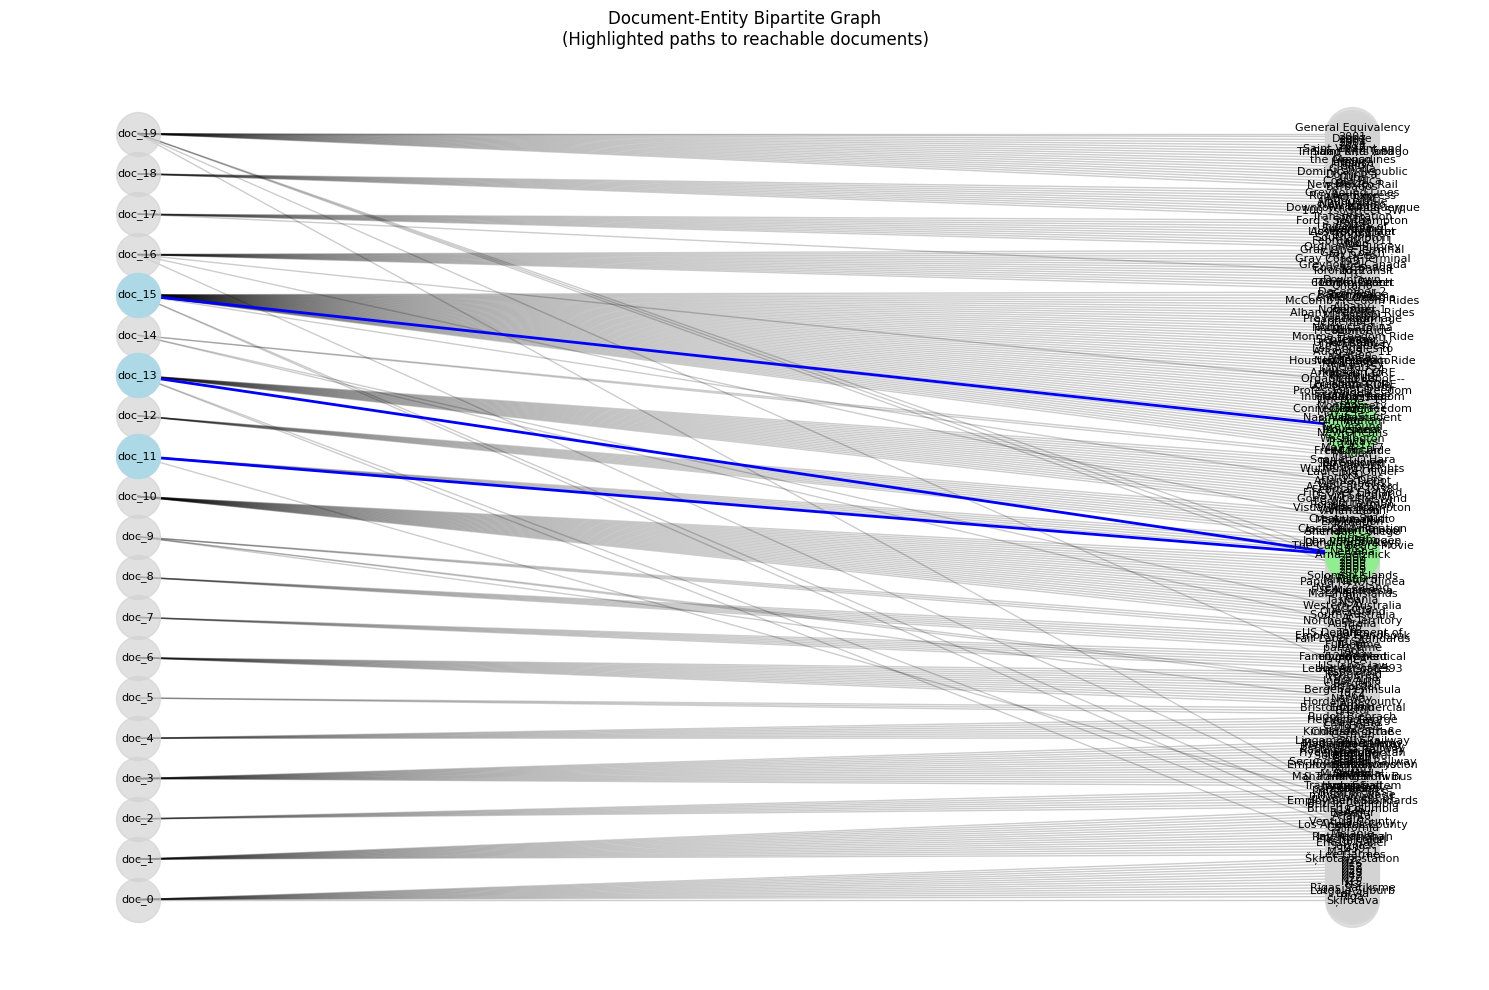

In [11]:
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import re
import textwrap
import networkx as nx
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from collections import defaultdict

def extract_entities(text: str, deepseek: DeepSeekAPI) -> List[str]:
    """Extract named entities from a given text using DeepSeek API"""
    messages = [
        {"role": "system", "content": "You are a helpful assistant for named entity extraction."},
        {"role": "user", "content": """Task: Extract named entities from the given text. Return ONLY a simple comma-separated list of entities.
Rules:
- Include names, organizations, locations, dates, and time periods
- Do NOT include category labels or bullet points
- Do NOT include line breaks
- Each entity should be a simple text without annotations
- Separate entities with commas only

Examples: Use the following examples to understand the task better.

Sentence: William Rast is an American clothing line founded by Justin Timberlake and Trace Ayala.
Entities: William Rast, American, Justin Timberlake, Trace Ayala

Sentence: The Glennwanis Hotel is a historic hotel in Glennville, Georgia, Tattnall County, Georgia, built on the site of the Hughes Hotel.
Entities: Glennwanis Hotel, Glennville, Georgia, Tattnall County, Georgia, Hughes Hotel

Now extract entities from this text:
""" + text + "\nEntities: "}
    ]
    
    response = deepseek.generate_response(messages, temperature=0)
    print(response)
    entities = response.strip()
    return [e.strip() for e in entities.split(",")]

def process_paragraph(args):
    """Helper function to process a single paragraph"""
    idx, para, deepseek = args
    entities = extract_entities(para['paragraph_text'], deepseek)
    print(f"Paragraph {idx}: {entities}")  # Debug print
    return idx, entities

def normalize_entity(entity: str) -> str:
    """Normalize entity text by removing common variations"""
    # Remove any content in brackets or parentheses
    entity = re.sub(r'\s*[\(\[].*?[\)\]]', '', entity)
    # Convert to lowercase and strip whitespace
    entity = entity.lower().strip()
    return entity

def are_entities_similar(entity1: str, entity2: str, threshold: int = 80) -> bool:
    """
    Check if two entities are similar using fuzzy string matching
    Returns True if entities are similar enough based on the threshold
    """
    # First check exact match after normalization
    norm1 = normalize_entity(entity1)
    norm2 = normalize_entity(entity2)
    
    if norm1 == norm2:
        return True
    
    # Then check fuzzy matching
    ratio = fuzz.ratio(norm1, norm2)
    token_ratio = fuzz.token_sort_ratio(norm1, norm2)
    return max(ratio, token_ratio) >= threshold

def find_paths_between_question_entities(G: nx.Graph, question_entities: List[str]) -> List[List[str]]:
    """Find all paths between question entities in the graph"""
    paths = []
    # Find all pairs of question entities
    for i, source in enumerate(question_entities):
        for target in question_entities[i+1:]:
            try:
                # Find all simple paths between the entities
                entity_paths = list(nx.all_simple_paths(G, source, target, cutoff=4))
                paths.extend(entity_paths)
            except nx.NetworkXNoPath:
                continue
    return paths

def get_documents_from_paths(paths: List[List[str]]) -> Set[str]:
    """Extract document nodes from paths"""
    documents = set()
    for path in paths:
        for node in path:
            if node.startswith('doc_'):
                documents.add(node)
    return documents

def merge_similar_entities(G: nx.Graph) -> nx.Graph:
    """
    Merge nodes that represent the same entity with different variations
    Returns a new graph with merged nodes
    """
    # Create new graph
    new_G = nx.Graph()
    
    # Get all entity nodes
    entities = [n for n, d in G.nodes(data=True) if d['node_type'] == 'entity']
    
    # Create mapping of similar entities
    entity_groups = defaultdict(list)
    processed = set()
    merge_count = 0
    merge_details = []
    
    # Group similar entities
    for entity in entities:
        if entity in processed:
            continue
            
        group = [entity]
        for other in entities:
            if other != entity and other not in processed:
                if are_entities_similar(entity, other):
                    group.append(other)
                    processed.add(other)
        
        # Use the shortest entity name as the canonical form
        canonical = min(group, key=len)
        
        # Track merges
        if len(group) > 1:
            merge_count += len(group) - 1
            merge_details.append(f"Merged {len(group)} entities into '{canonical}': {', '.join(group)}")
        
        for e in group:
            entity_groups[canonical].append(e)
        processed.add(entity)
    
    # Print merge statistics
    if merge_count > 0:
        print(f"\nMerged {merge_count} entities:")
        for detail in merge_details:
            print(detail)
    
    # Add document nodes as is
    for node, data in G.nodes(data=True):
        if data['node_type'] == 'document':
            new_G.add_node(node, **data)
    
    # Add merged entity nodes and redirect edges
    for canonical, variants in entity_groups.items():
        new_G.add_node(canonical, bipartite=1, node_type='entity')
        # Redirect all edges from variants to canonical form
        for variant in variants:
            for neighbor in G.neighbors(variant):
                new_G.add_edge(neighbor, canonical)
    
    return new_G

def create_entity_graph(example, deepseek: DeepSeekAPI, max_workers: int = 4):
    """Create a bipartite graph for a single example linking documents and entities"""
    G = nx.Graph()
    
    # Extract entities from the question
    print("Question:", example['question'])
    question_entities = extract_entities(example['question'], deepseek)
    print(f"\nEntities from question: {question_entities}")
    
    # Debug print
    print(f"\nTotal paragraphs: {len(example['paragraphs'])}")
    print(f"Supporting paragraphs: {sum(1 for p in example['paragraphs'] if p.get('is_supporting', False))}")
    
    # Process paragraphs in parallel
    args_list = [(i, para, deepseek) for i, para in enumerate(example['paragraphs'])]
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(
            executor.map(process_paragraph, args_list),
            total=len(args_list),
            desc="Processing paragraphs"
        ))
    
    # Create initial graph
    initial_entities = set()
    for idx, entities in results:
        if entities:
            doc_id = f"doc_{idx}"
            G.add_node(doc_id, bipartite=0, node_type='document')
            
            for entity in entities:
                if entity:
                    initial_entities.add(entity)
                    G.add_node(entity, bipartite=1, node_type='entity')
                    G.add_edge(doc_id, entity)
    
    print(f"\nInitial number of unique entities: {len(initial_entities)}")
    
    # Merge similar entities
    G = merge_similar_entities(G)
    final_entities = [n for n, d in G.nodes(data=True) if d['node_type'] == 'entity']
    print(f"Final number of unique entities after merging: {len(final_entities)}")
    
    # Find paths between question entities
    paths = find_paths_between_question_entities(G, question_entities)
    relevant_docs = get_documents_from_paths(paths)
    
    print(f"\nFound {len(paths)} paths between question entities")
    print(f"Relevant documents: {relevant_docs}")
    
    return G, paths, relevant_docs

def visualize_entity_graph(G, paths=None, relevant_docs=None):
    """Visualize the bipartite graph with highlighted paths and documents"""
    plt.figure(figsize=(15, 10))
    
    # Separate nodes by type
    docs = [n for n, d in G.nodes(data=True) if d['node_type'] == 'document']
    entities = [n for n, d in G.nodes(data=True) if d['node_type'] == 'entity']
    
    # Create layout
    pos = nx.bipartite_layout(G, docs)
    
    # Draw regular nodes and edges
    nx.draw_networkx_nodes(G, pos, nodelist=docs, node_color='lightgray', 
                          node_size=1000, alpha=0.7)
    nx.draw_networkx_nodes(G, pos, nodelist=entities, node_color='lightgray', 
                          node_size=1500, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    # Highlight paths if provided
    if paths:
        path_edges = set()
        path_nodes = set()
        for path in paths:
            path_nodes.update(path)
            path_edges.update(zip(path[:-1], path[1:]))
        
        # Highlight path nodes
        path_docs = [n for n in path_nodes if n.startswith('doc_')]
        path_entities = [n for n in path_nodes if not n.startswith('doc_')]
        
        if path_docs:
            nx.draw_networkx_nodes(G, pos, nodelist=path_docs, 
                                 node_color='lightblue', node_size=1000)
        if path_entities:
            nx.draw_networkx_nodes(G, pos, nodelist=path_entities, 
                                 node_color='lightgreen', node_size=1500)
        
        # Highlight path edges
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, 
                             edge_color='blue', width=2)
    
    # Add labels with smaller font and wrap long labels
    labels = {node: '\n'.join(textwrap.wrap(str(node), width=20)) 
             for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title("Document-Entity Bipartite Graph\n(Highlighted paths between question entities)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test the entity extraction and graph creation for one example
def test_entity_extraction():
    example = df.iloc[3]  # Get first example
    
    G, paths, relevant_docs = create_entity_graph(example, deepseek)
    print("\nGraph information:")
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())
    
    visualize_entity_graph(G, paths, relevant_docs)
    
def find_reachable_documents(G: nx.Graph, question_entities: List[str], max_depth: int = 4) -> Set[str]:
    """
    Find all documents reachable from question entities using BFS with max depth
    Returns set of document IDs and the paths used to reach them
    """
    reachable_docs = set()
    all_paths = []
    
    for start_entity in question_entities:
        # Keep track of depth and paths during BFS
        visited = {start_entity: 0}  # node -> depth
        queue = [(start_entity, [start_entity])]  # (node, path_to_node)
        
        while queue:
            current, path = queue.pop(0)
            current_depth = visited[current]
            
            if current_depth >= max_depth:
                continue
                
            for neighbor in G.neighbors(current):
                # If this is a document node, add it to results
                if neighbor.startswith('doc_'):
                    reachable_docs.add(neighbor)
                    all_paths.append(path + [neighbor])
                    continue
                
                # For entity nodes, continue BFS if not visited or at lower depth
                if neighbor not in visited or visited[neighbor] > current_depth + 1:
                    visited[neighbor] = current_depth + 1
                    queue.append((neighbor, path + [neighbor]))
    
    print(f"\nFound {len(reachable_docs)} reachable documents within {max_depth} steps:")
    for doc in sorted(reachable_docs):
        print(f"- {doc}")
        
    print(f"\nExample paths to documents:")
    for path in all_paths[:5]:  # Show first 5 paths as examples
        print(" -> ".join(path))
    
    return reachable_docs, all_paths

def create_entity_graph(example, deepseek: DeepSeekAPI, max_workers: int = 4):
    """Create a bipartite graph for a single example linking documents and entities"""
    G = nx.Graph()
    
    # Extract entities from the question
    print("Question:", example['question'])
    question_entities = extract_entities(example['question'], deepseek)
    print(f"\nEntities from question: {question_entities}")
    
    # Debug print
    print(f"\nTotal paragraphs: {len(example['paragraphs'])}")
    print(f"Supporting paragraphs: {sum(1 for p in example['paragraphs'] if p.get('is_supporting', False))}")
    
    # Process paragraphs in parallel
    args_list = [(i, para, deepseek) for i, para in enumerate(example['paragraphs'])]
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(
            executor.map(process_paragraph, args_list),
            total=len(args_list),
            desc="Processing paragraphs"
        ))
    
    # Create initial graph
    initial_entities = set()
    for idx, entities in results:
        if entities:
            doc_id = f"doc_{idx}"
            G.add_node(doc_id, bipartite=0, node_type='document')
            
            for entity in entities:
                if entity:
                    initial_entities.add(entity)
                    G.add_node(entity, bipartite=1, node_type='entity')
                    G.add_edge(doc_id, entity)
    
    print(f"\nInitial number of unique entities: {len(initial_entities)}")
    
    # Merge similar entities
    G = merge_similar_entities(G)
    final_entities = [n for n, d in G.nodes(data=True) if d['node_type'] == 'entity']
    print(f"Final number of unique entities after merging: {len(final_entities)}")
    
    # Find reachable documents from question entities
    relevant_docs, paths = find_reachable_documents(G, question_entities, max_depth=4)
    
    return G, paths, relevant_docs

def visualize_entity_graph(G, paths=None, relevant_docs=None):
    """Visualize the bipartite graph with highlighted paths and documents"""
    plt.figure(figsize=(15, 10))
    
    # Separate nodes by type
    docs = [n for n, d in G.nodes(data=True) if d['node_type'] == 'document']
    entities = [n for n, d in G.nodes(data=True) if d['node_type'] == 'entity']
    
    # Create layout
    pos = nx.bipartite_layout(G, docs)
    
    # Draw regular nodes and edges
    nx.draw_networkx_nodes(G, pos, nodelist=docs, node_color='lightgray', 
                          node_size=1000, alpha=0.7)
    nx.draw_networkx_nodes(G, pos, nodelist=entities, node_color='lightgray', 
                          node_size=1500, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    # Highlight paths if provided
    if paths:
        path_edges = set()
        path_nodes = set()
        for path in paths:
            path_nodes.update(path)
            path_edges.update(zip(path[:-1], path[1:]))
        
        # Highlight path nodes
        path_docs = [n for n in path_nodes if n.startswith('doc_')]
        path_entities = [n for n in path_nodes if not n.startswith('doc_')]
        
        if path_docs:
            nx.draw_networkx_nodes(G, pos, nodelist=path_docs, 
                                 node_color='lightblue', node_size=1000)
        if path_entities:
            nx.draw_networkx_nodes(G, pos, nodelist=path_entities, 
                                 node_color='lightgreen', node_size=1500)
        
        # Highlight path edges
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, 
                             edge_color='blue', width=2)
    
    # Add labels with smaller font and wrap long labels
    labels = {node: '\n'.join(textwrap.wrap(str(node), width=20)) 
             for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title("Document-Entity Bipartite Graph\n(Highlighted paths to reachable documents)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Run the test
test_entity_extraction()

In [8]:
example = df.iloc[3]
# Get the document IDs from the paragraphs
doc_ids = [p['idx'] for p in example['paragraphs'] if p['is_supporting']]
print("Supporting document IDs:", doc_ids)

Supporting document IDs: [11, 12, 16]


In [10]:
example['question_decomposition']

[{'id': 241001,
  'question': 'Arna Selznick >> employer',
  'answer': 'Nelvana',
  'paragraph_support_idx': 11},
 {'id': 568433,
  'question': '#1 >> headquarters location',
  'answer': 'Toronto',
  'paragraph_support_idx': 12},
 {'id': 47686,
  'question': 'where do greyhound buses leave from in #2',
  'answer': 'Toronto Coach Terminal',
  'paragraph_support_idx': 16}]